# I. Introduction

- Nama: Cylia Wardana

- Batch: HCK - 004

### Title: **Forecasting Product Quantity for the Upcoming Quarter Using Time Series Analysis**

### Desription

Time-series analysis adalah metode statistik yang digunakan untuk menganalisis data yang dikumpulkan selama periode waktu tertentu. Dalam konteks ini, metode ini digunakan untuk meramalkan kuantitas produk yang akan terjual pada kuartal mendatang. Dengan menganalisis data historis tentang penjualan produk, tren, dan pola musiman, time-series analysis dapat memberikan informasi yang berharga tentang kuantitas produk yang akan terjual pada periode waktu tertentu. Dengan demikian, informasi ini dapat digunakan oleh perusahaan untuk merencanakan produksi dan mengelola persediaan dengan lebih efektif, sehingga dapat mengoptimalkan proses produksi dan meningkatkan keuntungan.

# II. Import Libraries

In [2]:
#change datatime data type
from datetime import datetime

#calculation
import numpy as np
import pandas as pd

#visualization
import matplotlib.pylab as plt
%matplotlib inline

#stationery test
from statsmodels.tsa.stattools import adfuller

#model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#forecasting visualization
from statsmodels.tsa.seasonal import seasonal_decompose

#modelling
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings(action='ignore')

# III. Data Loading

In [3]:
#load data dan cek non-standard missing values
missing_values = ["n/a", "na", "--",'?',' nan', 'no',' ?','NaN','nan']
data = pd.read_csv('sample_dataset_timeseries_noarea.csv',na_values=missing_values)

In [4]:
#buat copy dari data
df = data.copy()

In [5]:
df.shape

(102733, 5)

Terdapat 102733 baris dan 5 kolom pada dataset ini

In [6]:
#untuk mengetahui tipe data dari tiap kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   week_number      102733 non-null  object
 1   week_start_date  102733 non-null  object
 2   week_end_date    102733 non-null  object
 3   product_item     102731 non-null  object
 4   quantity         102733 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


In [7]:
#melihat apakah terdapat missing value
df.isnull().sum()

week_number        0
week_start_date    0
week_end_date      0
product_item       2
quantity           0
dtype: int64

In [8]:
#melihat baris mana yang terdapat missing value
df.loc[df.isnull().any(axis=1)]

,week_number,week_start_date,week_end_date,product_item,quantity
18048,2022-12,2022-03-21,2022-03-27,NaN,119
19536,2022-13,2022-03-28,2022-04-03,NaN,147


Terdapat missing value pada kolom produk (terdapat produk yang tidak diketahui) namun pada kolom quantity terdapat nilainya oleh karena itu baris ini tidak akan dihilangkan

In [9]:
#menampilkan 5 baris pertama
df.head()

,week_number,week_start_date,week_end_date,product_item,quantity
0,2021-52,2021-12-27,2022-01-02,0073377087c7ddace313ff829cd7b0b3,41
1,2021-52,2021-12-27,2022-01-02,012d2bb142b2d5e57330acbfd8e9ac52,430
2,2021-52,2021-12-27,2022-01-02,0192926e33d1153b63511a5b83eca843,4
3,2021-52,2021-12-27,2022-01-02,019502f6d13e383caa9b9673bf1302f8,148
4,2021-52,2021-12-27,2022-01-02,01e7ca6d4e21badc1d4225b6b2c7bd9e,119


In [10]:
#menampilkan 5 baris terakhir
df.tail()

,week_number,week_start_date,week_end_date,product_item,quantity
102728,2023-14,2023-04-03,2023-04-09,ff3890faa80ff425ae906e27bbc50bc6,907
102729,2023-14,2023-04-03,2023-04-09,ff4b0f3b9c78c91510a4e3920fbc5090,81
102730,2023-14,2023-04-03,2023-04-09,ff9d05a4d6f922b3ab1653f58165b8ce,16
102731,2023-14,2023-04-03,2023-04-09,ffbd6f1d884056a4f622d54ae79e5a14,42920
102732,2023-14,2023-04-03,2023-04-09,fff18f7c705e729746515e2053dee64b,53


In [11]:
#melihat apakah ada baris duplikat
df.duplicated().sum()

0

In [12]:
#mengganti kolom-kolom ini menjadi tipe datetime
df[['week_start_date','week_end_date']]=df[['week_start_date','week_end_date']].apply(pd.to_datetime)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102733 entries, 0 to 102732
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   week_number      102733 non-null  object        
 1   week_start_date  102733 non-null  datetime64[ns]
 2   week_end_date    102733 non-null  datetime64[ns]
 3   product_item     102731 non-null  object        
 4   quantity         102733 non-null  int64         
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 3.9+ MB


# IV. Exploratory Data Analysis

In [14]:
df.product_item.describe()

count                               102731
unique                                2309
top       0073377087c7ddace313ff829cd7b0b3
freq                                    67
Name: product_item, dtype: object

Terdapat total 2309 produk / item

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,102733.0,3191.562419,12074.631014,0.0,75.0,414.0,1890.0,774732.0


Rata-rata quantity keseluruhan produk adalah 3191 dengan produk yang paling banyak terjual pada suatu produk mencapai 774732

In [16]:
#melihat rata-rata dan total penjualan setiap produk, serta penjualan terbanyak dan terendah dari suatu produk
df.groupby('product_item')[['quantity']].aggregate(['mean','sum','max','min']).round()

quantity                      
                                     mean      sum     max  min
product_item                                                   
00450b4fde94b528b4255b4f6f51599d    253.0    15691     627    2
0065e8b533cd2c8273529312a6e8f219    543.0    29334    1843   27
0073377087c7ddace313ff829cd7b0b3    144.0     9645     486    4
0098d23d332c193a07eabaf0f703d4e5   3252.0   214632    7113  899
009e12e8fd2ef0b77047206e939fc6b9    857.0    39402    1573  107
...                                   ...      ...     ...  ...
ff92741956851dca5a1daafeef1d9dd7     16.0       16      16   16
ff9d05a4d6f922b3ab1653f58165b8ce     16.0       16      16   16
ffbd6f1d884056a4f622d54ae79e5a14  52730.0  3532900  112978  537
ffdf02b13a7c56d736d6a5ca701d936b     12.0      218      55    2
fff18f7c705e729746515e2053dee64b    161.0    10596     453   53

[2309 rows x 4 columns]

In [17]:
#melihat 5 produk dengan penjualan tertinggi
df.groupby('product_item')[['quantity']].sum().sort_values(by=['quantity'],ascending= False).head()

,quantity
product_item,
2949ca4cfbf13969bccfbb9817f2526a,18206376
2db7ed9bd7573aec037aac59237cb3dd,9122007
160eb16a7369a645ec75caa3f14543d4,6771207
229a936943f7da9feea525f1a48d1d03,6658518
0f9d1e065ad64ecd7237084107a4bfbd,4202082


Terdapat 1 produk yang memiliki penjualan diatas 15 juta unit

In [18]:
#menghitung keseluruhan produk terjual tiap minggunya
df.groupby('week_number')[['quantity']].sum()

,quantity
week_number,
2021-52,128808
2022-01,3839557
2022-02,4138934
2022-03,4149077
2022-04,4824273
...,...
2023-10,4775638
2023-11,4787111
2023-12,4757590


Terdapat total 67 minggu pada dataset ini

<Axes: title={'center': 'Total Products Per Week'}, xlabel='Week', ylabel='Quantity'>

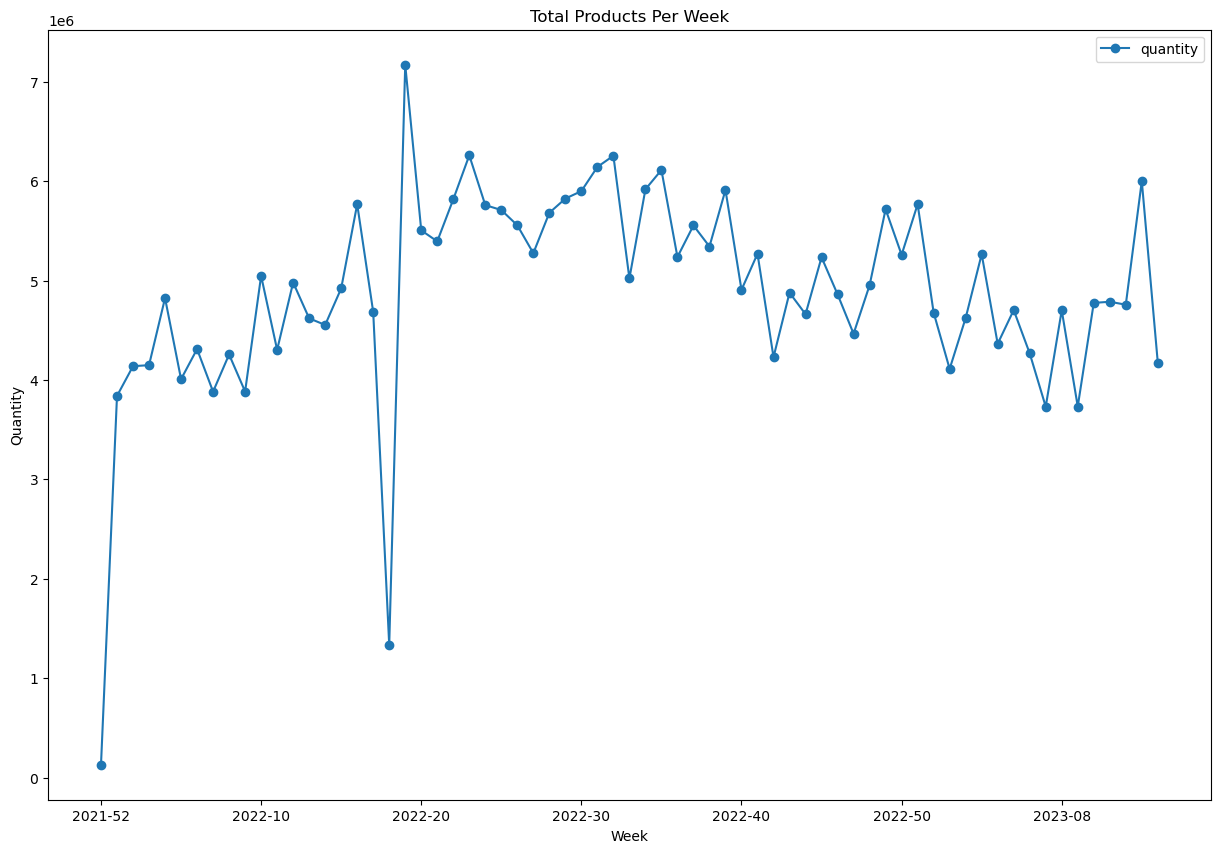

In [19]:
#membuat line plot berdasarkan informasi diatas
df.groupby('week_number')[['quantity']].sum().plot(kind='line',figsize=(15,10),title='Total Products Per Week',xlabel='Week',ylabel='Quantity',marker='o')

In [20]:
#melihat informasi minggu ke-18 tahun 2022
df[df['week_number']=='2022-18']

,week_number,week_start_date,week_end_date,product_item,quantity
25581,2022-18,2022-05-02,2022-05-08,00450b4fde94b528b4255b4f6f51599d,69
25582,2022-18,2022-05-02,2022-05-08,0065e8b533cd2c8273529312a6e8f219,215
25583,2022-18,2022-05-02,2022-05-08,0073377087c7ddace313ff829cd7b0b3,28
25584,2022-18,2022-05-02,2022-05-08,0098d23d332c193a07eabaf0f703d4e5,899
25585,2022-18,2022-05-02,2022-05-08,00b21b77bbe70ca3b33125402cfaa7b4,22
...,...,...,...,...,...
26928,2022-18,2022-05-02,2022-05-08,ff24eb021c575c9a1dc709c3f8d6631a,243
26929,2022-18,2022-05-02,2022-05-08,ff3890faa80ff425ae906e27bbc50bc6,329
26930,2022-18,2022-05-02,2022-05-08,ff4b0f3b9c78c91510a4e3920fbc5090,7
26931,2022-18,2022-05-02,2022-05-08,ffbd6f1d884056a4f622d54ae79e5a14,4748


In [21]:
#total penjualan week 18, 2022
df[df['week_number']=='2022-18'].quantity.sum()

1334134

In [22]:
#rata-rata total penjualan selama 67 minggu
(df.quantity.sum())/67

4893713.164179104

Terdapat penurunan penjualan yang cukup drastis pada minggu ke-18 tahun 2022 yaitu pada tanggal 2 mei - 8 mei 2022 dengan total penjualan 1.334.134 unit, dimana jumlah ini lebih rendah daripada rata-rata total penjualan selama 67 minggu pada dataset ini yaitu 4.893.713

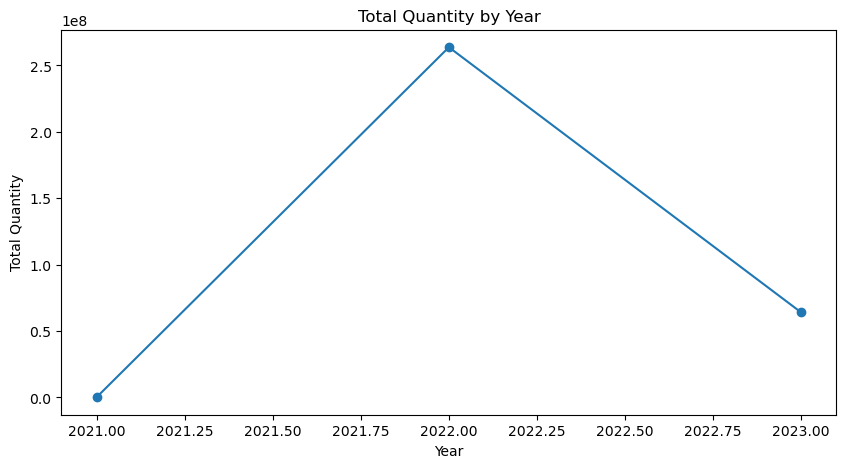

In [23]:
#membuat line plot untuk mengetahui total penjualan per tahun
start_date = pd.Timestamp('2021-12-27')
end_date = pd.Timestamp('2023-04-03')
df_filtered = df.loc[(df['week_start_date'] >= start_date) & (df['week_start_date'] <= end_date)]

df_filtered = df_filtered.set_index('week_start_date')

df_year = df_filtered.groupby(df_filtered.index.year)

df_sum = df_year.sum()

fig, ax = plt.subplots(figsize=(10, 5), sharex=True)

ax.plot(df_sum.index, df_sum['quantity'], marker='o')
ax.set_xlabel('Year')
ax.set_ylabel('Total Quantity')
ax.set_title('Total Quantity by Year')

plt.show()

Berdasarkan line plot, total penjualan tertinggi ada pada tahun 2022, namun hal ini tidak bisa menjadi patokan karena data yang tersedia pada tahun 2021 hanya ada pada bulan Desember saja dan pada tahun 2023 hanya masih sampai bulan april saja dimana bulannya masih akan berjalan

In [24]:
#membuat kolom baru untuk meng-ekstrak bulan dan tahun dari kolom week_start_date
df['year_month'] = pd.to_datetime(df['week_start_date']).dt.strftime('%Y-%m')

In [25]:
df['year_month']

0         2021-12
1         2021-12
2         2021-12
3         2021-12
4         2021-12
           ...   
102728    2023-04
102729    2023-04
102730    2023-04
102731    2023-04
102732    2023-04
Name: year_month, Length: 102733, dtype: object

<Axes: title={'center': 'Total Product Quantity Per Month From 2021 - 2023'}, xlabel='month and year', ylabel='Quantity'>

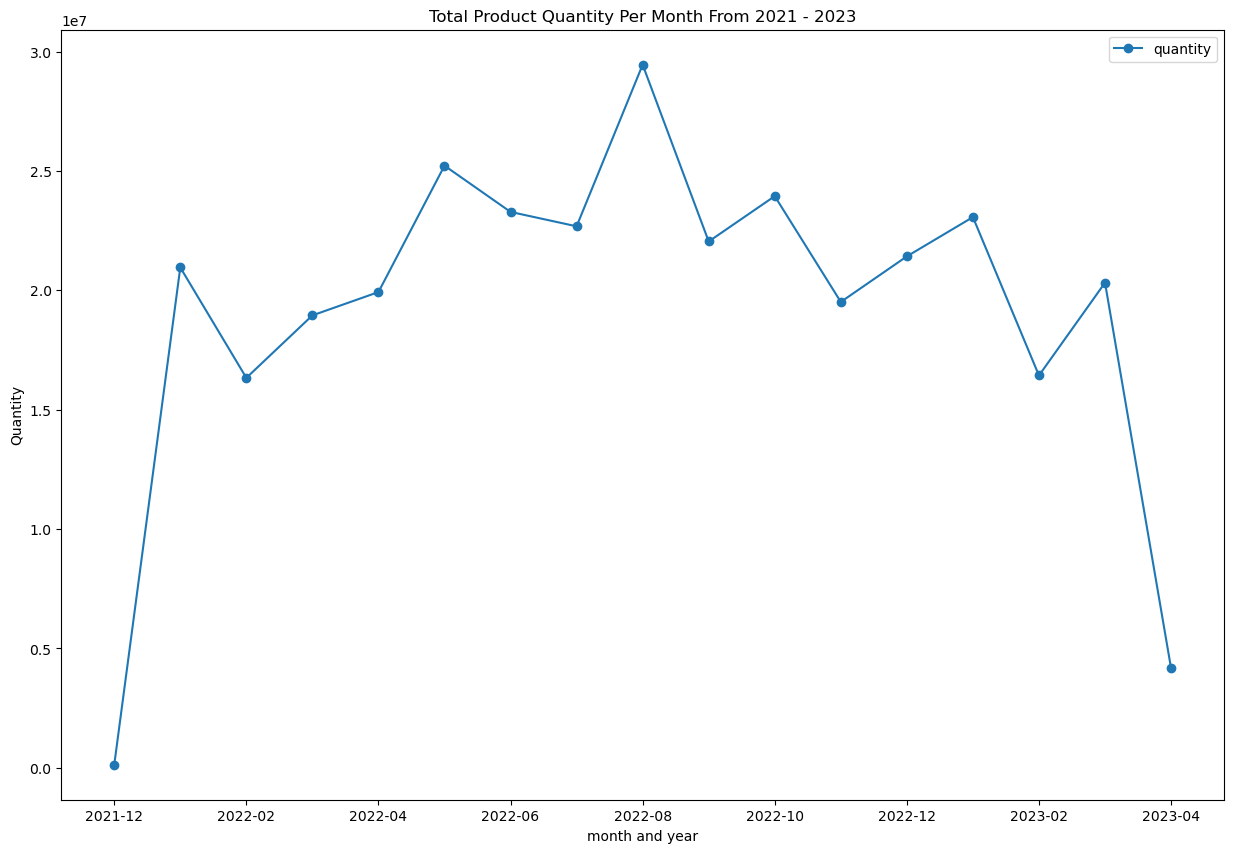

In [26]:
#membuat line plot berdasarkan bulan dan tahun yang sudah diekstrak
df.groupby('year_month')[['quantity']].sum().plot(kind='line',figsize=(15,10),marker='o',ylabel='Quantity',xlabel='month and year',title='Total Product Quantity Per Month From 2021 - 2023')

Pada grafik diatas bisa disimpulkan bahwa penjualan tertinggi/memuncak ada pada pertengahan tahun (pada bulan agustus), ini bisa terjadi karena pada bulan-bulan tersebut memang merupakan holiday season untuk anak-anak sekolah maupun kuliah sehingga lebih banyak waktu untuk berbelanja.

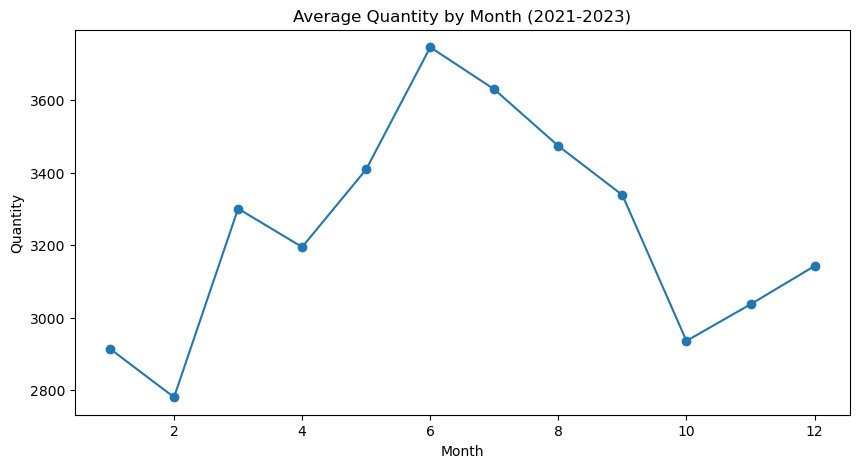

In [27]:
#line plot untuk mengetahui rata-rata penjualan tiap bulan (rata-rata dari 2021- 2023)
start_date = pd.Timestamp('2021-12-27')
end_date = pd.Timestamp('2023-04-03')
df_filtered = df.loc[(df['week_start_date'] >= start_date) & (df['week_start_date'] <= end_date)]

df_filtered = df_filtered.set_index('week_start_date')

df_year = df_filtered.groupby(df_filtered.index.month)

df_mean = df_year.mean()

fig, ax = plt.subplots(figsize=(10, 5), sharex=True)

ax.plot(df_mean.index, df_mean['quantity'], marker='o')
ax.set_xlabel('Month')
ax.set_ylabel('Quantity')
ax.set_title('Average Quantity by Month (2021-2023)')

plt.show()

Terlihat pada grafik diatas bahwa rata-rata penjualan per bulan tahun 2021-2023 akan naik / memuncak pada pertengahan tahun (menghitung rata-rata daripada sum/jumlah karena pada dataset ini hanya ada satu tahun saja yang menampilkan seluruh bulan yaitu tahun 2022)

In [28]:
#membuat dataframe baru yang berisikan 2 kolom
df2 = df.iloc[:,[1,4]]

In [29]:
#menjumlahkan seluruh penjualan produk per minggu dan membuat variabel berdasarkan informasi tersebut
df3 = df2.groupby('week_start_date')[['quantity']].sum()
df3

,quantity
week_start_date,
2021-12-27,128808
2022-01-03,3839557
2022-01-10,4138934
2022-01-17,4149077
2022-01-24,4824273
...,...
2023-03-06,4775638
2023-03-13,4787111
2023-03-20,4757590


Variabel inilah yang nantinya akan digunakan untuk keperluan modelling

### Seasonal Decomposition

<Figure size 640x480 with 0 Axes>

<Figure size 5000x2500 with 0 Axes>

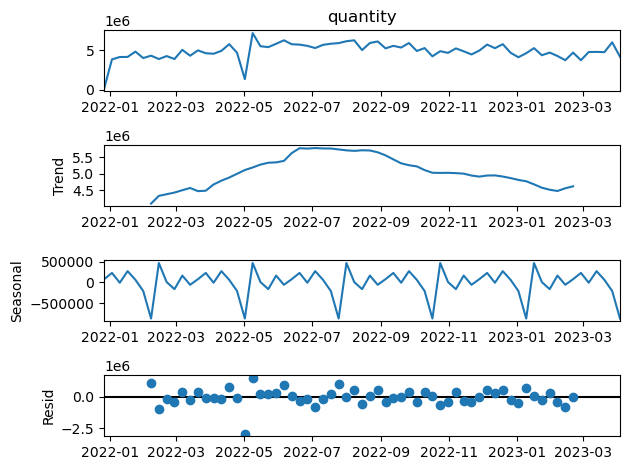

In [30]:
fig = plt.figure() 
fig = plt.figure(figsize=(50,25))

result = seasonal_decompose(df3['quantity'],model='additive',period=12)
 
fig = result.plot()

<Figure size 640x480 with 0 Axes>

<Figure size 5000x2500 with 0 Axes>

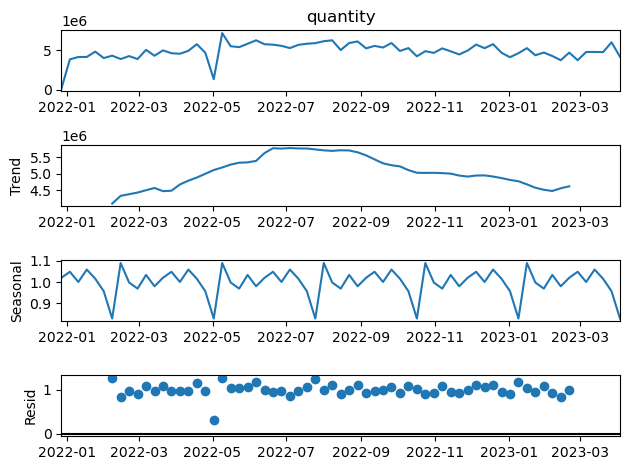

In [31]:
fig = plt.figure() 
fig = plt.figure(figsize=(50,25))

result = seasonal_decompose(df3['quantity'],model='multiplicative',period=12)
 
fig = result.plot()

Terlihat adanya seasonality pada kedua graph diatas, terdapat perbedaan pada gambar residu dimana pada gambar residu diatas yaitu 'additive' memilki range sampai 0 sampai -2.5 sedangkan gambar residu dibawahnya 'multiplicative' memiliki range dari 0-1.

### Stationary Test

In [32]:
#function untuk menghitung stationery test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [33]:
adf_test(df3)

ADF Statistic: -3.328832
p-value: 0.013638


P-value kurang dari 0.05 (<0.05) yang berarti data ini stationer dan tidak perlu handling stationary

### Autocorrelation

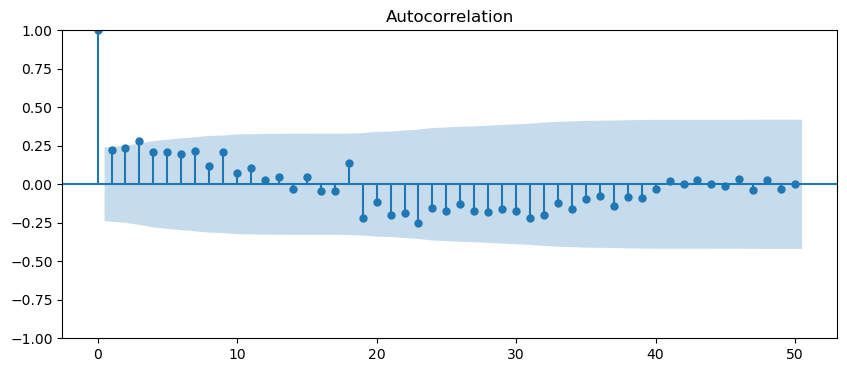

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
acf_plot = plot_acf(df3, lags=50,ax=ax)

ACF membantu mengidentifikasi Moving Average Model (nilai q), berdasarkan grafik, q yang akan dipilih adalah 0

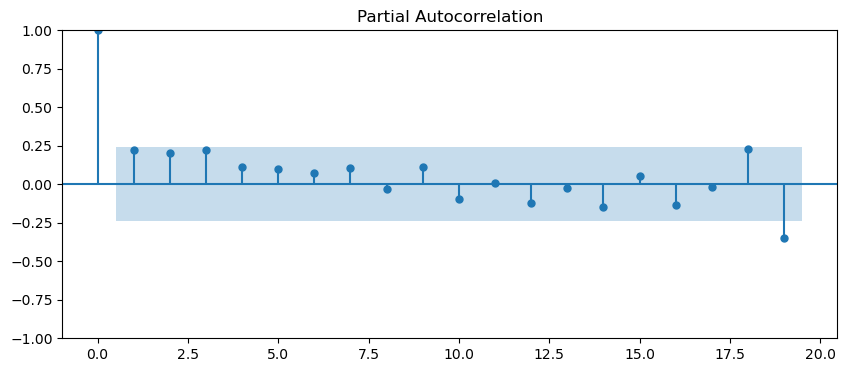

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
pacf_plot = plot_pacf(df3,ax=ax)

Berdasarkan PACF, nilai p yang akan dicoba pada Auto Regressive model adalah 19

### Split

In [36]:
train_data, test_data = df3[0:int(len(df3)*0.8)], df3[int(len(df3)*0.8):]

Membagi train set dan test set dengan perbandingan 80:20

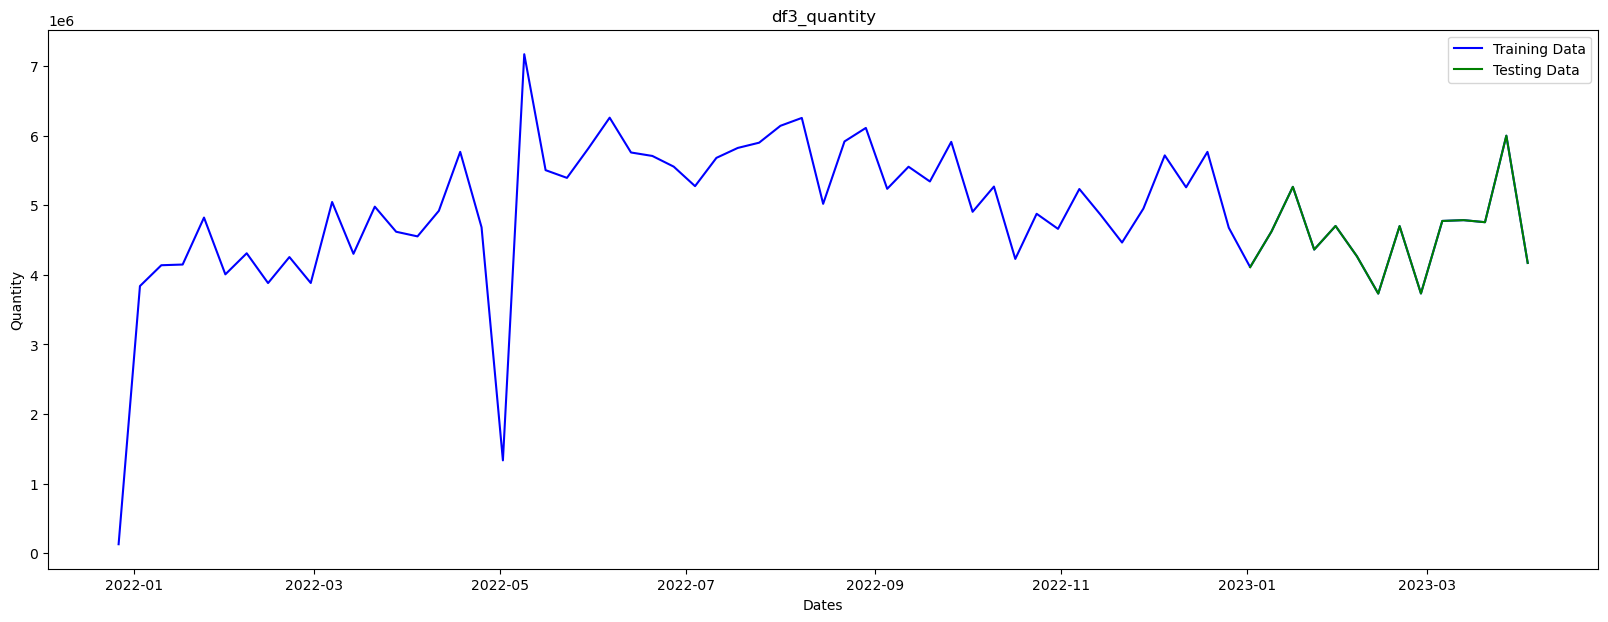

In [37]:
#line plot merepresentasikan train dan test set
plt.figure(figsize=(20,7))
plt.title('df3_quantity')
plt.xlabel('Dates')
plt.ylabel('Quantity')
plt.plot(df3['quantity'], 'blue', label='Training Data')
plt.plot(test_data['quantity'], 'green', label='Testing Data')
plt.legend()

# V. Model Definition

Selanjutnya, akan dilakukan modelling dengan menggunakan model ARMA dan Holt-Winters:

#### ARMA Model

In [38]:
model_arma = ARIMA(train_data, order=(19,0,3))
model1 = model_arma.fit()

In [39]:
predictions = model1.forecast(steps=len(test_data))

Text(0, 0.5, 'Quantity')

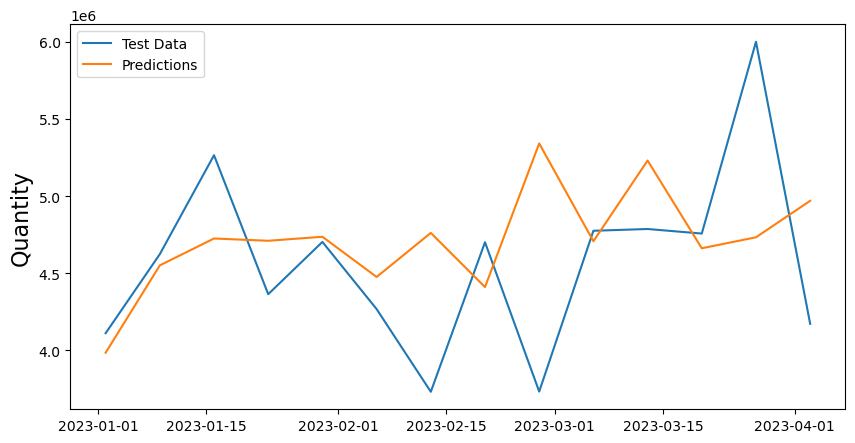

In [40]:
plt.figure(figsize=(10,5))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Test Data', 'Predictions'), fontsize=10)

plt.ylabel('Quantity', fontsize=16)

### Holt-Winters (Additive)

In [41]:
exp_model_add = ExponentialSmoothing(train_data ,seasonal_periods=12 ,trend="add", seasonal='add',use_boxcox=True).fit(optimized=True)
predictions2 = exp_model_add.forecast(len(test_data))

Text(0, 0.5, 'Quantity')

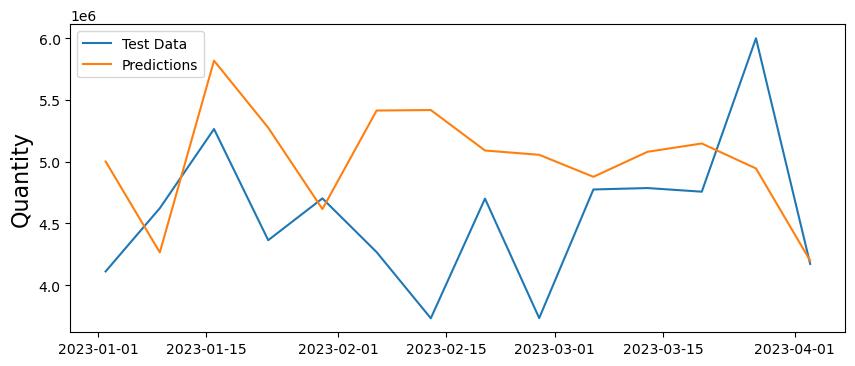

In [42]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions2)

plt.legend(('Test Data', 'Predictions'), fontsize=10)

plt.ylabel('Quantity', fontsize=16)

### Holt-Winters (Multiplicative)

In [43]:
exp_model_mul = ExponentialSmoothing(train_data ,seasonal_periods=12 ,trend="add", seasonal='mul',use_boxcox=True).fit(optimized=True)
predictions3 = exp_model_mul.forecast(len(test_data))

Text(0, 0.5, 'Quantity')

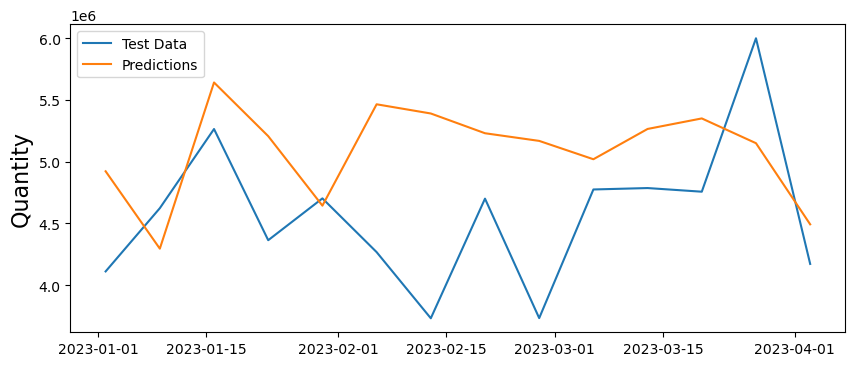

In [44]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions3)

plt.legend(('Test Data', 'Predictions'), fontsize=10)

plt.ylabel('Quantity', fontsize=16)

# VI. Model Evaluation

In [45]:
(df.quantity.sum())/67

4893713.164179104

Rata-rata keseluruhan untuk dibandingkan dengan rentang error yang dihasilkan model

### ARMA Model

In [46]:
mape = mean_absolute_percentage_error(predictions, test_data)
mae = mean_absolute_error(predictions,test_data)

print('MAPE:', round(mape,3))
print('MAE:', round(mae))

MAPE: 0.101
MAE: 495036


### Holt-Winters (Additive)

In [47]:
mape = mean_absolute_percentage_error(predictions2, test_data)
mae = mean_absolute_error(predictions2,test_data)

print('MAPE:', round(mape,3))
print('MAE:', round(mae))

MAPE: 0.128
MAE: 658620


### Holt-Winters (Multiplicative)

In [48]:
mape = mean_absolute_percentage_error(predictions3, test_data)
mae = mean_absolute_error(predictions3,test_data)

print('MAPE:', round(mape,3))
print('MAE:', round(mae))

MAPE: 0.134
MAE: 695233


Jika dibandingkan, model ARMA memiliki MAPE / persentase mean absolute error terkecil daripada model lainnya yaitu 0.10% walaupun sebenarnya hasil dari model lainnya tidak berbeda jauh, oleh karena itu model ARMA yang akan digunakan untuk membuat forecast (dengan rentang error 495.036 dibandingkan dengan rata-rata keseluruhannya yaitu 4.893.713)

# VII. Forecast

In [49]:
#forecast 13 minggu kedepan
forecast_arma = model1.predict(start = len(df3), end = (len(df3)-1) + 13)

In [50]:
forecast_arma

2023-04-10    5.390278e+06
2023-04-17    4.690333e+06
2023-04-24    4.901564e+06
2023-05-01    4.110598e+06
2023-05-08    4.293396e+06
2023-05-15    4.704963e+06
2023-05-22    5.149777e+06
2023-05-29    5.183917e+06
2023-06-05    5.193290e+06
2023-06-12    5.329693e+06
2023-06-19    5.342632e+06
2023-06-26    5.206006e+06
2023-07-03    5.540904e+06
Freq: W-MON, Name: predicted_mean, dtype: float64

In [51]:
#hasil forecast 13 minggu kedepan
forecast_df = pd.DataFrame(forecast_arma)
forecast_df = forecast_df.rename(columns={'predicted_mean': 'Forecast'})
forecast_df

,Forecast
2023-04-10,5.390278e+06
2023-04-17,4.690333e+06
2023-04-24,4.901564e+06
2023-05-01,4.110598e+06
2023-05-08,4.293396e+06
2023-05-15,4.704963e+06
2023-05-22,5.149777e+06
2023-05-29,5.183917e+06
2023-06-05,5.193290e+06
2023-06-12,5.329693e+06


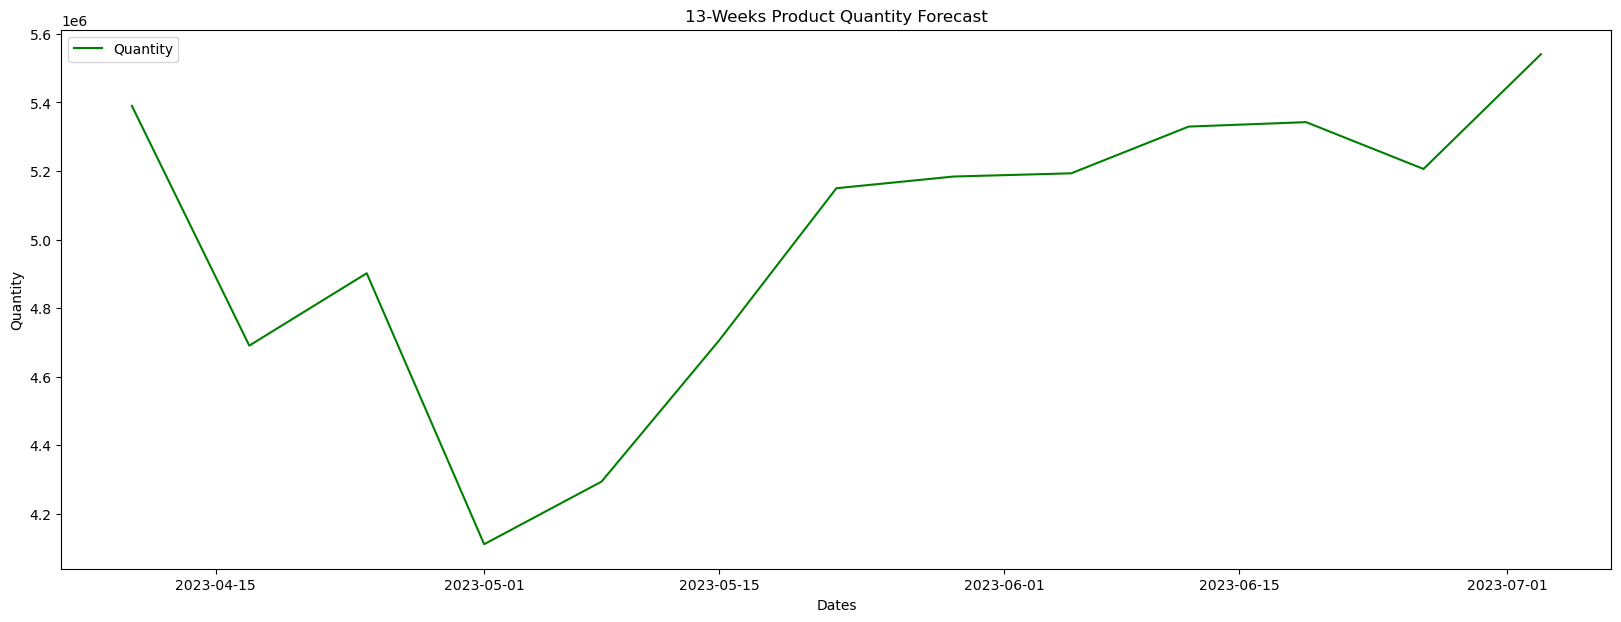

In [53]:
#plot result
plt.figure(figsize=(20,7))
plt.plot(forecast_df, color='green', label='Quantity')
plt.title('13-Weeks Product Quantity Forecast')
plt.xlabel('Dates')
plt.ylabel('Quantity')
plt.legend()

Terlihat model ARMA berhasil memberikan forecast 13 minggu kedepan / forecast pada Q2 tahun 2023 dan terlihat adanya kenaikan menjelang pertengahan tahun dimana hal ini selaras dengan tahun sebelumnya / 2022

# VIII. Conclusion

- Model ARMA mampu membuat forecast untuk kuartal mendatang, dimana pada forecast yang telah dibuat terlihat trendnya sama dengan tahun sebelumnya yaitu akan memuncak pada pertengahan tahun

- Model ARMA hanya menghasilkan error sebesar 0.10% dengan rentang error sebesar 495.000

- Perusahaan dapat mengoptimalkan produksi dan manajemen persediaan mereka dengan lebih efektif dengan memperhitungkan pola musiman dan tren dalam data historis

- Dalam jangka panjang, penggunaan time-series analysis ini dapat membantu perusahaan meningkatkan efisiensi dan keuntungan mereka serta mempertahankan kompetitivitas di pasar